In [24]:
import pandas
import keras
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pathlib
from sklearn.model_selection import train_test_split

%matplotlib inline

In [25]:
# CLASSIFIER PARAMETERS
class_col = 'blueWins'

# TRAINING PARAMETERS
n_layers = 1
n_neurons = 8
hidden_neuron_activation = 'tanh' # 'tanh', 'relu', 'sigmoid'
my_metric = 'Accuracy' # 'Precision', 'Recall', 'Accuracy'
min_improvement = 0.01
my_patience = 500
base_max_epoch = 10*my_patience
optimizer_name = 'adam' # 'sgd', 'adam', 'rmsprop'
lr = 0.001
n_k_folds = 5
hyperconfig_stat = 'mean' # 'mean', 'median', 'max', 'min'
loss_function = "mse"
activation_type = 'sigmoid' # 'linear', 'logistic', 'softmax'


# CONTROL RANDOMNESS
random_seed = 33

In [26]:
# SET THE RANDOM SEED
keras.utils.set_random_seed(random_seed)

In [27]:
# BUILD PATH TO DATA USING PATHLIB
this_folder = pathlib.Path.cwd()
data_folder = this_folder.parent
path_to_rankedLOL = data_folder / 'datasets' / 'high_diamond_ranked_10min.csv'
games = pandas.read_csv(path_to_rankedLOL)

In [28]:
games["gold_diff"] = games["blueGoldDiff"]
games["exp_diff"] = games["blueExperienceDiff"]
games["kills_diff"] = games["blueKills"] - games["redKills"]
games["dragons_diff"] = games["blueDragons"] - games["redDragons"]
games["deaths_diff"] = games["blueDeaths"] - games["redDeaths"]

# Selecionar apenas alvo + features finais
games = games[[
    "blueWins", "gold_diff", "exp_diff", "kills_diff", "dragons_diff", "deaths_diff"
]]

In [29]:
my_vars = list(games.columns[games.columns != class_col])
df_X = games[my_vars]
one_hot = OneHotEncoder(sparse_output=False)
df_Y_categorical = games[[class_col]]
Y_array_categorical = df_Y_categorical.to_numpy()
one_hot.fit(Y_array_categorical)
df_Y = pandas.DataFrame(one_hot.transform(Y_array_categorical))
df_Y.columns = one_hot.categories_
n_classes = df_Y.columns.shape[0]

# PREPARE DATA
X = df_X.to_numpy()
Y = df_Y.to_numpy()

# NORMALIZE VARIABLES
X_scaler = StandardScaler()
X_scaler = X_scaler.fit(X)
X_scaled = X_scaler.transform(X)

# BASE TRAINING LOOP
X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y, test_size=0.2, random_state=random_seed)

# TRAINING LOOP
    
# DECLARE NET
inputs = keras.Input(shape=(len(my_vars), ))
hidden = keras.layers.Dense(n_neurons, activation=hidden_neuron_activation)(inputs)
#hidden = keras.layers.Dense(4, activation=hidden_neuron_activation)(hidden)
bnorm = keras.layers.BatchNormalization()(hidden)
outputs = keras.layers.Dense(n_classes, activation=activation_type)(bnorm)
model_name = f'{optimizer_name.upper()}-{hidden_neuron_activation.upper()}-N{n_neurons}'
my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
val_metric_name = 'val_{}'.format(my_metric)

match optimizer_name:
    case 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=lr)
    case 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    case 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=lr)
    case _:
        raise ValueError(f'Optimizer {optimizer_name} not recognized')

my_net.compile(optimizer=optimizer, loss=loss_function, metrics=[my_metric])
es_loss = keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
es_metric = keras.callbacks.EarlyStopping(monitor=my_metric, mode='max', patience=my_patience, min_delta=min_improvement, restore_best_weights=True)

# FIT
history = my_net.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=X_train.shape[0], epochs=base_max_epoch, verbose=0, callbacks=[es_loss, es_metric])

# UNPACK TRAINING RESULTS
model_loss = history.history['loss'][-1]
model_val_loss = history.history['val_loss'][-1]
metric_val = history.history[my_metric][-1]
val_metric_val = history.history[val_metric_name][-1]
n_epochs = len(history.history['val_loss'])
result_dict = {'model_name': model_name,
                'optimizer_name' : optimizer_name,
                'loss': model_loss,
                'val_loss': model_val_loss,
                my_metric: metric_val,
                val_metric_name: val_metric_val,
                'epochs': n_epochs,
                'net': my_net,
                'history': history}
print(f'{model_name} > epochs: {n_epochs} loss: {model_loss:.2f} val_loss: {model_val_loss:.2f} {my_metric}: {100.0*metric_val:.0f}% {val_metric_name}: {100.0*val_metric_val:.0f}%')


ADAM-TANH-N8 > epochs: 585 loss: 0.18 val_loss: 0.19 Accuracy: 74% val_Accuracy: 72%


NameError: name 'best_final_history' is not defined

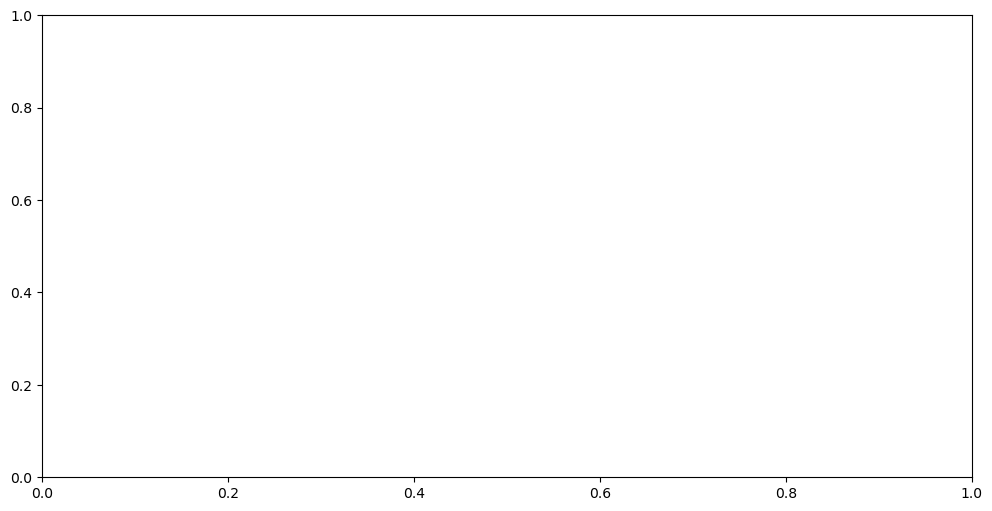

In [ ]:
# PLOT TRAINING HISTORY
fig = pyplot.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
_ = ax.plot(history.history['loss'], label='loss')
_ = ax.plot(history.history['val_loss'], label='val_loss')
_ = ax.grid(which='major', linestyle='--', linewidth='0.5', color='gray')
_ = ax.legend()